In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from utils import *
from img_utils import *

2024-03-14 14:51:20.179189: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 14:51:20.179260: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-14 14:51:20.243444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-14 14:51:20.373617: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-14 14:51:22.011793: W tensorflow/compiler/tf2

# Loading Data 

In [3]:
path = "../nybolig-scrape/output"
houses_df = data_to_DF(path, max_houses=1000)
print("Number of datapoints of type 'Ejerlejlighed': ", len(houses_df))
display(houses_df)

[ WARN:0@6.101] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.103] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.106] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.194] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.489] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.491] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.700] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.705] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check file path/integrity
[ WARN:0@6.725] global loadsave.cpp:248 findDecoder imread_(''): can't open/read file: check fil

Number of datapoints of type 'Ejerlejlighed':  735


,address,postal_code,type,price,size,basement_size,rooms,year_built,year_rebuilt,energy_label,image_floorplan
0,Acaciavej 1 1. 1867 Frederiksberg C,1867,ejerlejlighed,9995000,124,None,4.0,1875.0,2022.0,B,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,Agerskovvej 4D 2. 2610 Rødovre,2610,ejerlejlighed,1995000,70,None,2.0,1968.0,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
2,Agerskovvej 4M st. 2610 Rødovre,2610,ejerlejlighed,2195000,70,None,2.0,1968.0,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
3,Aggersborggade 9 1. tv 2100 København Ø,2100,ejerlejlighed,5650000,80,None,3.0,1896.0,1933.0,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
4,Aggersvoldvej 3B 3. 2700 Brønshøj,2700,ejerlejlighed,2725000,66,None,3.0,1934.0,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
...,...,...,...,...,...,...,...,...,...,...,...
730,Ørnevej 46 1. tv. 2400 København NV,2400,ejerlejlighed,3295000,70,None,2.0,1925.0,NaN,D,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
731,Øster Allé 22 1. 2100 København Ø,2100,ejerlejlighed,9995000,122,None,4.0,1900.0,NaN,B,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
732,Østerbrogade 224 1. th 2100 København Ø,2100,ejerlejlighed,3645000,70,None,2.0,1938.0,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
733,Østerbrogade 224 4. th. 2100 København Ø,2100,ejerlejlighed,4295000,70,None,3.0,1938.0,NaN,C,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


# Setting up splits

In [4]:
from sklearn.model_selection import train_test_split

# Split the data into train, validation and test sets with a 60-20-20 ratio
train_df, test_df = train_test_split(houses_df, test_size=0.2, random_state=0)
train_df, valid_df = train_test_split(train_df, test_size=0.20, random_state=0)

Train set length:      470
Validation set length: 118
Test set length:       147
[3400000.0]
[3400000.0]
[3400000.0]


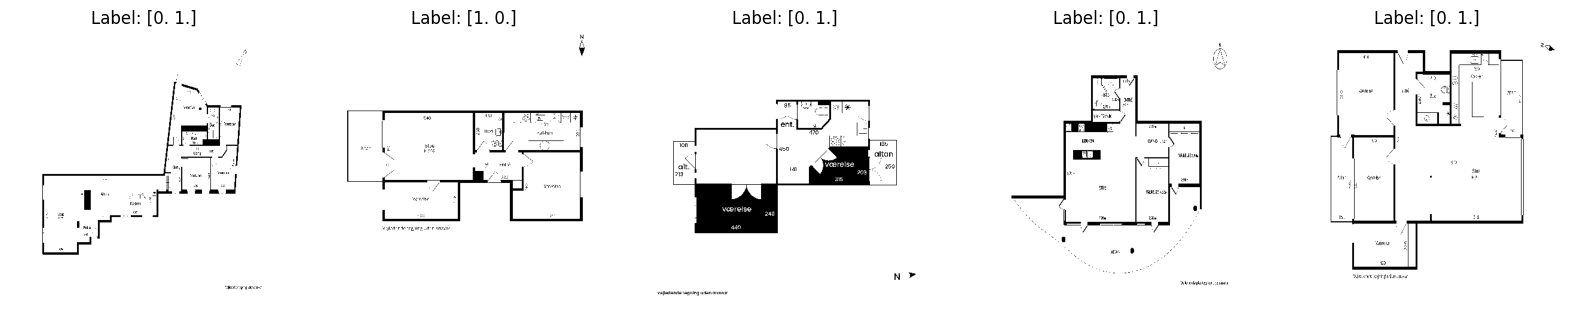

In [10]:
target_width = 448
target_height = 448

resize: bool = True
gray_scale: bool = False
threshhold: bool = True

train_images_RGB = preprocess_images(train_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
validation_images_RGB = preprocess_images(valid_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)
test_images_RGB = preprocess_images(test_df, "image_floorplan", target_width, target_height, resize = resize, gray_scale = gray_scale, threshhold = threshhold)

print(f"Train set length:      {len(train_images_RGB)}")
print(f"Validation set length: {len(validation_images_RGB)}")
print(f"Test set length:       {len(test_images_RGB)}")

num_labels = 2

train_labels = prices_to_n_labels(houses_df['price'], train_df['price'], num_labels)
valid_labels = prices_to_n_labels(houses_df['price'], valid_df['price'], num_labels)
test_labels = prices_to_n_labels(houses_df['price'], test_df['price'], num_labels)

#Plot the first 5 images and their labels
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(train_images_RGB[i])
    ax[i].set_title(f"Label: {(train_labels[i])}")
    ax[i].axis('off')
plt.show()

# Pre-trained VGG16

## Model Fitting

2024-03-14 15:02:45.254101: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:45.277620: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:45.277715: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:45.280850: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:45.281006: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU


2024-03-14 15:02:45.472645: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:45.473002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:45.473043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-03-14 15:02:45.473227: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:02:45.473282: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created

Model: "VGG16_classification_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 14, 14, 512)       14714688  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                        

2024-03-14 15:02:48.856449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-14 15:02:49.043517: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-14 15:02:49.759446: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-14 15:02:50.798490: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.62GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-14 15:02:51.131780: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran o

15/15 [==============================] - 62s 2s/step - loss: 1.1253 - accuracy: 0.5745 - val_loss: 3.2823 - val_accuracy: 0.4746
Epoch 2/100
15/15 [==============================] - 10s 694ms/step - loss: 0.8939 - accuracy: 0.6255 - val_loss: 1.9800 - val_accuracy: 0.5424
Epoch 3/100
15/15 [==============================] - 7s 472ms/step - loss: 0.8904 - accuracy: 0.6489 - val_loss: 1.5326 - val_accuracy: 0.5763
Epoch 4/100
15/15 [==============================] - 7s 474ms/step - loss: 0.6232 - accuracy: 0.7553 - val_loss: 1.3715 - val_accuracy: 0.5847
Epoch 5/100
15/15 [==============================] - 7s 442ms/step - loss: 0.4666 - accuracy: 0.8043 - val_loss: 1.1516 - val_accuracy: 0.6441
Epoch 6/100
15/15 [==============================] - 7s 453ms/step - loss: 0.4167 - accuracy: 0.8404 - val_loss: 1.0092 - val_accuracy: 0.6610
Epoch 7/100
15/15 [==============================] - 7s 445ms/step - loss: 0.3441 - accuracy: 0.8532 - val_loss: 0.8761 - val_accuracy: 0.6864
Epoch 8/100


INFO:tensorflow:Assets written to: ./VGG16_classification_model/assets


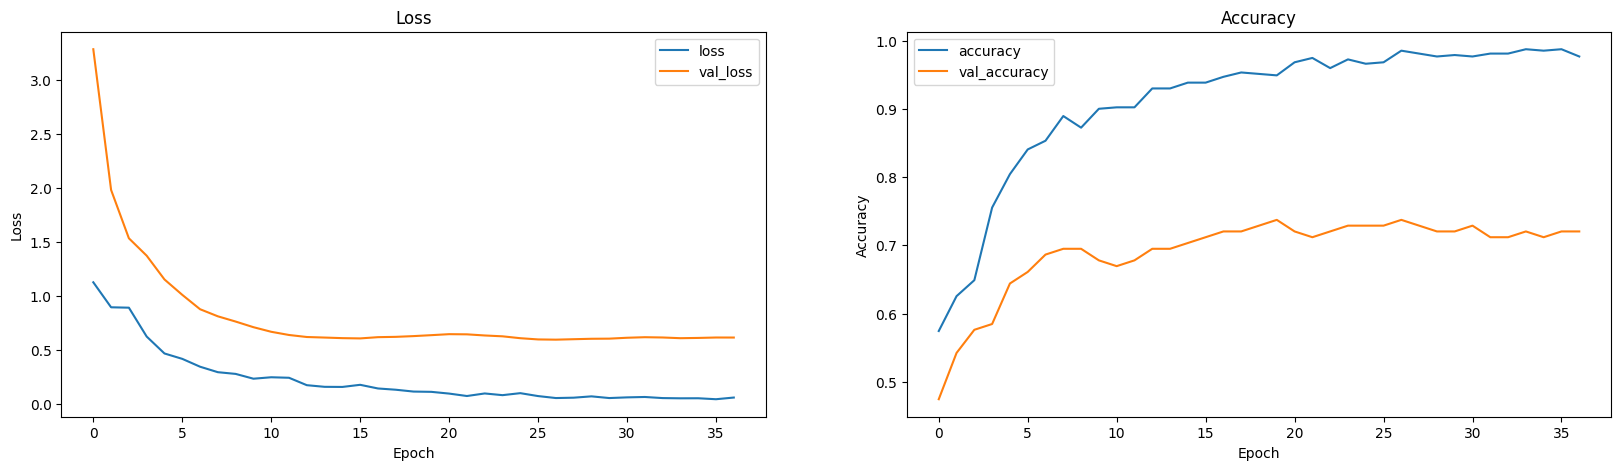

In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from multiprocessing import Process, Queue

def train_model(fine_tune_layers: int = 0):
    """
    Train a model with the VGG16 architecture and save the model to disk.
    
    Args:
        fine_tune_layers (int): Number of layers to fine-tune, counting from the top of the model.
    """
    set_gpu()
    
    # Load pre-trained VGG16 model (excluding top layers)
    input_shape = train_images_RGB[0].shape 
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the pre-trained layers
    for layer in base_model.layers[:-fine_tune_layers] if fine_tune_layers > 0 else base_model.layers:
        layer.trainable = False

    # Add new top layers for regression
    model = Sequential([
        base_model,
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(num_labels, activation='softmax')
    ], name='VGG16_classification_model')

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    # Train the model with early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(train_images_RGB, train_labels, validation_data=(validation_images_RGB, valid_labels), epochs=100, callbacks=[early_stopping])
    # history = model.fit(train_images_RGB, train_labels, validation_data=(validation_images_RGB, valid_labels), epochs=100)


    model.save("./VGG16_classification_model")

    # Plot the loss and accuracy
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].set_title('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].set_title('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend()
    plt.show()

p = Process(target=train_model, args=(0,))
p.start()
p.join()

In [12]:
# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(256, activation='relu'),
#     Dropout(0.2),
#     Dense(num_labels, activation='softmax')
# ])
# labels = 2
# learning_rate = 0.00001
# epochs = 100
# patience = 10
# results:
#               precision    recall  f1-score   support

#            0       0.71      0.74      0.73        70
#            1       0.76      0.73      0.74        77

#     accuracy                           0.73       147
#    macro avg       0.73      0.74      0.73       147
# weighted avg       0.74      0.73      0.73       147

# labels = 5
# learning_rate = 0.00001
# epochs = 100
# patience = 30
# results:
#               precision    recall  f1-score   support

#            0       0.38      0.46      0.41        26
#            1       0.41      0.24      0.30        29
#            2       0.28      0.42      0.33        26
#            3       0.21      0.17      0.19        29
#            4       0.47      0.43      0.45        37

#     accuracy                           0.35       147
#    macro avg       0.35      0.35      0.34       147
# weighted avg       0.36      0.35      0.34       147

# model = Sequential([
#     base_model,
#     Flatten(),
#     Dense(512, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(num_labels, activation='softmax')
# ], name='VGG16_classification_model')
# labels = 2
# learning_rate = 0.00001
# epochs = 100
# patience = 10
# results:
#               precision    recall  f1-score   support

#            0       0.72      0.80      0.76        70
#            1       0.80      0.71      0.75        77

#     accuracy                           0.76       147
#    macro avg       0.76      0.76      0.76       147
# weighted avg       0.76      0.76      0.76       147

## Model Evaluation

In [15]:
def evaluate_model(queue: Queue):
    set_gpu()
    
    # Evaluate the model
    loaded_model = tf.keras.models.load_model("./VGG16_classification_model")
    loaded_model.evaluate(test_images_RGB, test_labels)
    predictions: np.ndarray = loaded_model.predict(test_images_RGB)
    
    queue.put(predictions)

queue = Queue()
p = Process(target=evaluate_model, args=(queue,))
p.start()
p.join()

if queue.empty():
    raise ValueError("Nothing was returned from the process")
predictions = queue.get()
real_labels = np.argmax(test_labels, axis=1)
predicted_labels = np.argmax(predictions, axis=1)

2024-03-14 15:49:28.539982: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:49:28.823561: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:49:28.823674: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:49:28.900813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:49:28.901370: I external/local_xla/xla/stream_executor

1 Physical GPUs, 1 Logical GPU


2024-03-14 15:49:29.644507: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:49:29.645756: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:49:29.646256: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2022] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-03-14 15:49:29.646451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-14 15:49:29.646499: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created

ValueError: Nothing was returned from the process

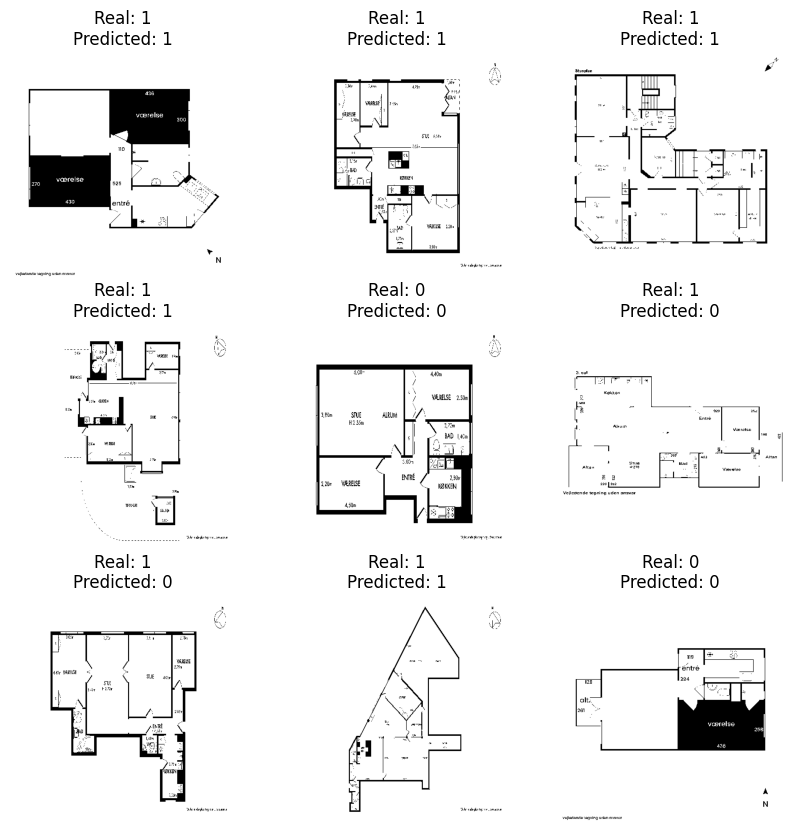

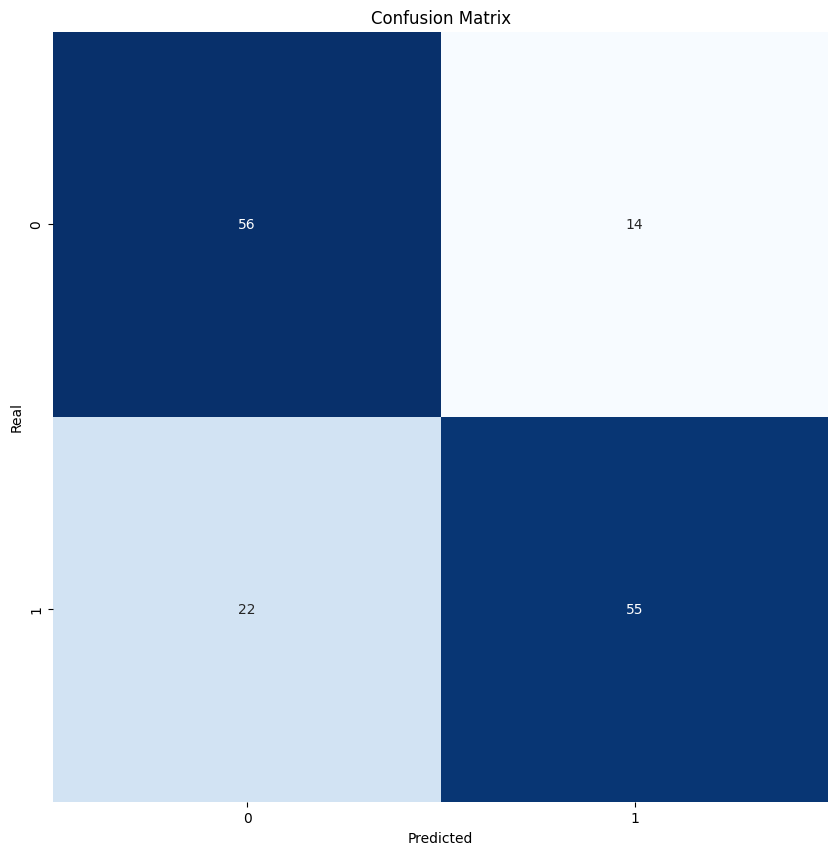

              precision    recall  f1-score   support

           0       0.72      0.80      0.76        70
           1       0.80      0.71      0.75        77

    accuracy                           0.76       147
   macro avg       0.76      0.76      0.76       147
weighted avg       0.76      0.76      0.76       147



In [14]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, r2_score, mean_absolute_error as mae, mean_squared_error as mse

# Plot the predictions
plt.figure(figsize=(10, 10))
for i, (image, label, prediction) in enumerate(zip(test_images_RGB[:9], real_labels[:9], predicted_labels[:9])):
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Real: {label}\nPredicted: {prediction}")
    plt.axis("off")
plt.show()

# Plot the confusion matrix
confusion = confusion_matrix(real_labels, predicted_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Real')
plt.title('Confusion Matrix')
plt.show()

# Plot the classification report
print(classification_report(real_labels, predicted_labels))

# Plot the ROC curve
# fpr, tpr, thresholds = roc_curve(real_labels, predicted_labels)
# plt.figure(figsize=(10, 10))
# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1], 'k--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()